# About

This notebook is written to restore single cell interaction analyzing code snippets related to artcle \<The spatial atlas of cholestatic injury and repair in mice\>.

For this part, we use [CellChat](https://github.com/jinworks/CellChat)([Jin, S., Guerrero-Juarez, C.F., Zhang, L. et al., *Nature Communication*, 2021](https://doi.org/10.1038/s41467-021-21246-9)) to analyzing cell-cell interactions. Show D0 interactions as an example.

Last edit at : 2023-12-11

Author: Xinyi Shentu

In [6]:
# Required packages
library("Seurat")
library("CellChat")

In [9]:
whatCellChat <- function(obj) {
    require("CellChat")
    require("patchwork")
    options(stringsAsFactors = FALSE)
    
    data.input <- obj@assays$RNA@data
    meta <- obj@meta.data
    # Remove reductant idents
    meta$active.ident <- droplevels(meta$active.ident, 
                                    exclude = setdiff(levels(meta$active.ident),unique(meta$active.ident)))
    
    # Create a CellChat obj
    cellchat <- createCellChat(object = data.input, meta = meta, group.by = "active.ident")
            
    # Set the ligand-receptor interaction database
    CellChatDB <- CellChatDB.mouse

    # use all CellChatDB for cell-cell communication analysis
    CellChatDB.use <- CellChatDB # simply use the default CellChatDB

    # set the used database in the object
    cellchat@DB <- CellChatDB.use

    # Preprocessing the expression data for cell-cell communication analysis
    cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database

    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <- identifyOverExpressedInteractions(cellchat)
    # project gene expression data onto PPI network (optional)
    cellchat <- projectData(cellchat, PPI.mouse)
            
    # Compute the communication probability and infer cellular communication network
    cellchat <- computeCommunProb(cellchat)

    # Infer the cell-cell communication at a signaling pathway level
    cellchat <- computeCommunProbPathway(cellchat)

    # Calculate the aggregated cell-cell communication network
    cellchat <- aggregateNet(cellchat)

    groupSize <- as.numeric(table(cellchat@idents))

    mat <- cellchat@net$weight
    for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
    }
    
    return(list(cellchat = cellchat, groupSize = groupSize, mat = mat, mat2 = mat2))
}

In [10]:
# D0 as an example
sc <- readRDS("CIRSTA_scRNA_D0_annotated.rds")
sc$active.ident <- factor(sc$anno_LPLCsubtype)

cellchat_D0_s <- whatCellChat(sc)

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  B cell cDC Cholangiocyte Fibroblast Hep HSC ILC1 KC LAM LPLC_1 LPLC_2 LSEC LyEC Mesothelial cell Monocyte Neutrophil NK PC_LVEC pDC PP_LVEC Proliferating hep T cell 
Issue identified!! Please check the official Gene Symbol of the following genes:  
 H2-BI H2-Ea-ps 


Comparing communications on a single object 




,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence,source.target,prob.original
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>
609,Cholangiocyte,Cholangiocyte,Agrn,Dag1,0.2525689,3,AGRN_DAG1,Agrn - Dag1,AGRN,ECM-Receptor,KEGG: mmu04512,Cholangiocyte -> Cholangiocyte,0.019076174
610,Cholangiocyte,Fibroblast,Agrn,Dag1,0.2746666,3,AGRN_DAG1,Agrn - Dag1,AGRN,ECM-Receptor,KEGG: mmu04512,Cholangiocyte -> Fibroblast,0.026231945
611,Cholangiocyte,Hep,Agrn,Dag1,0.1694169,3,AGRN_DAG1,Agrn - Dag1,AGRN,ECM-Receptor,KEGG: mmu04512,Cholangiocyte -> Hep,0.002732337


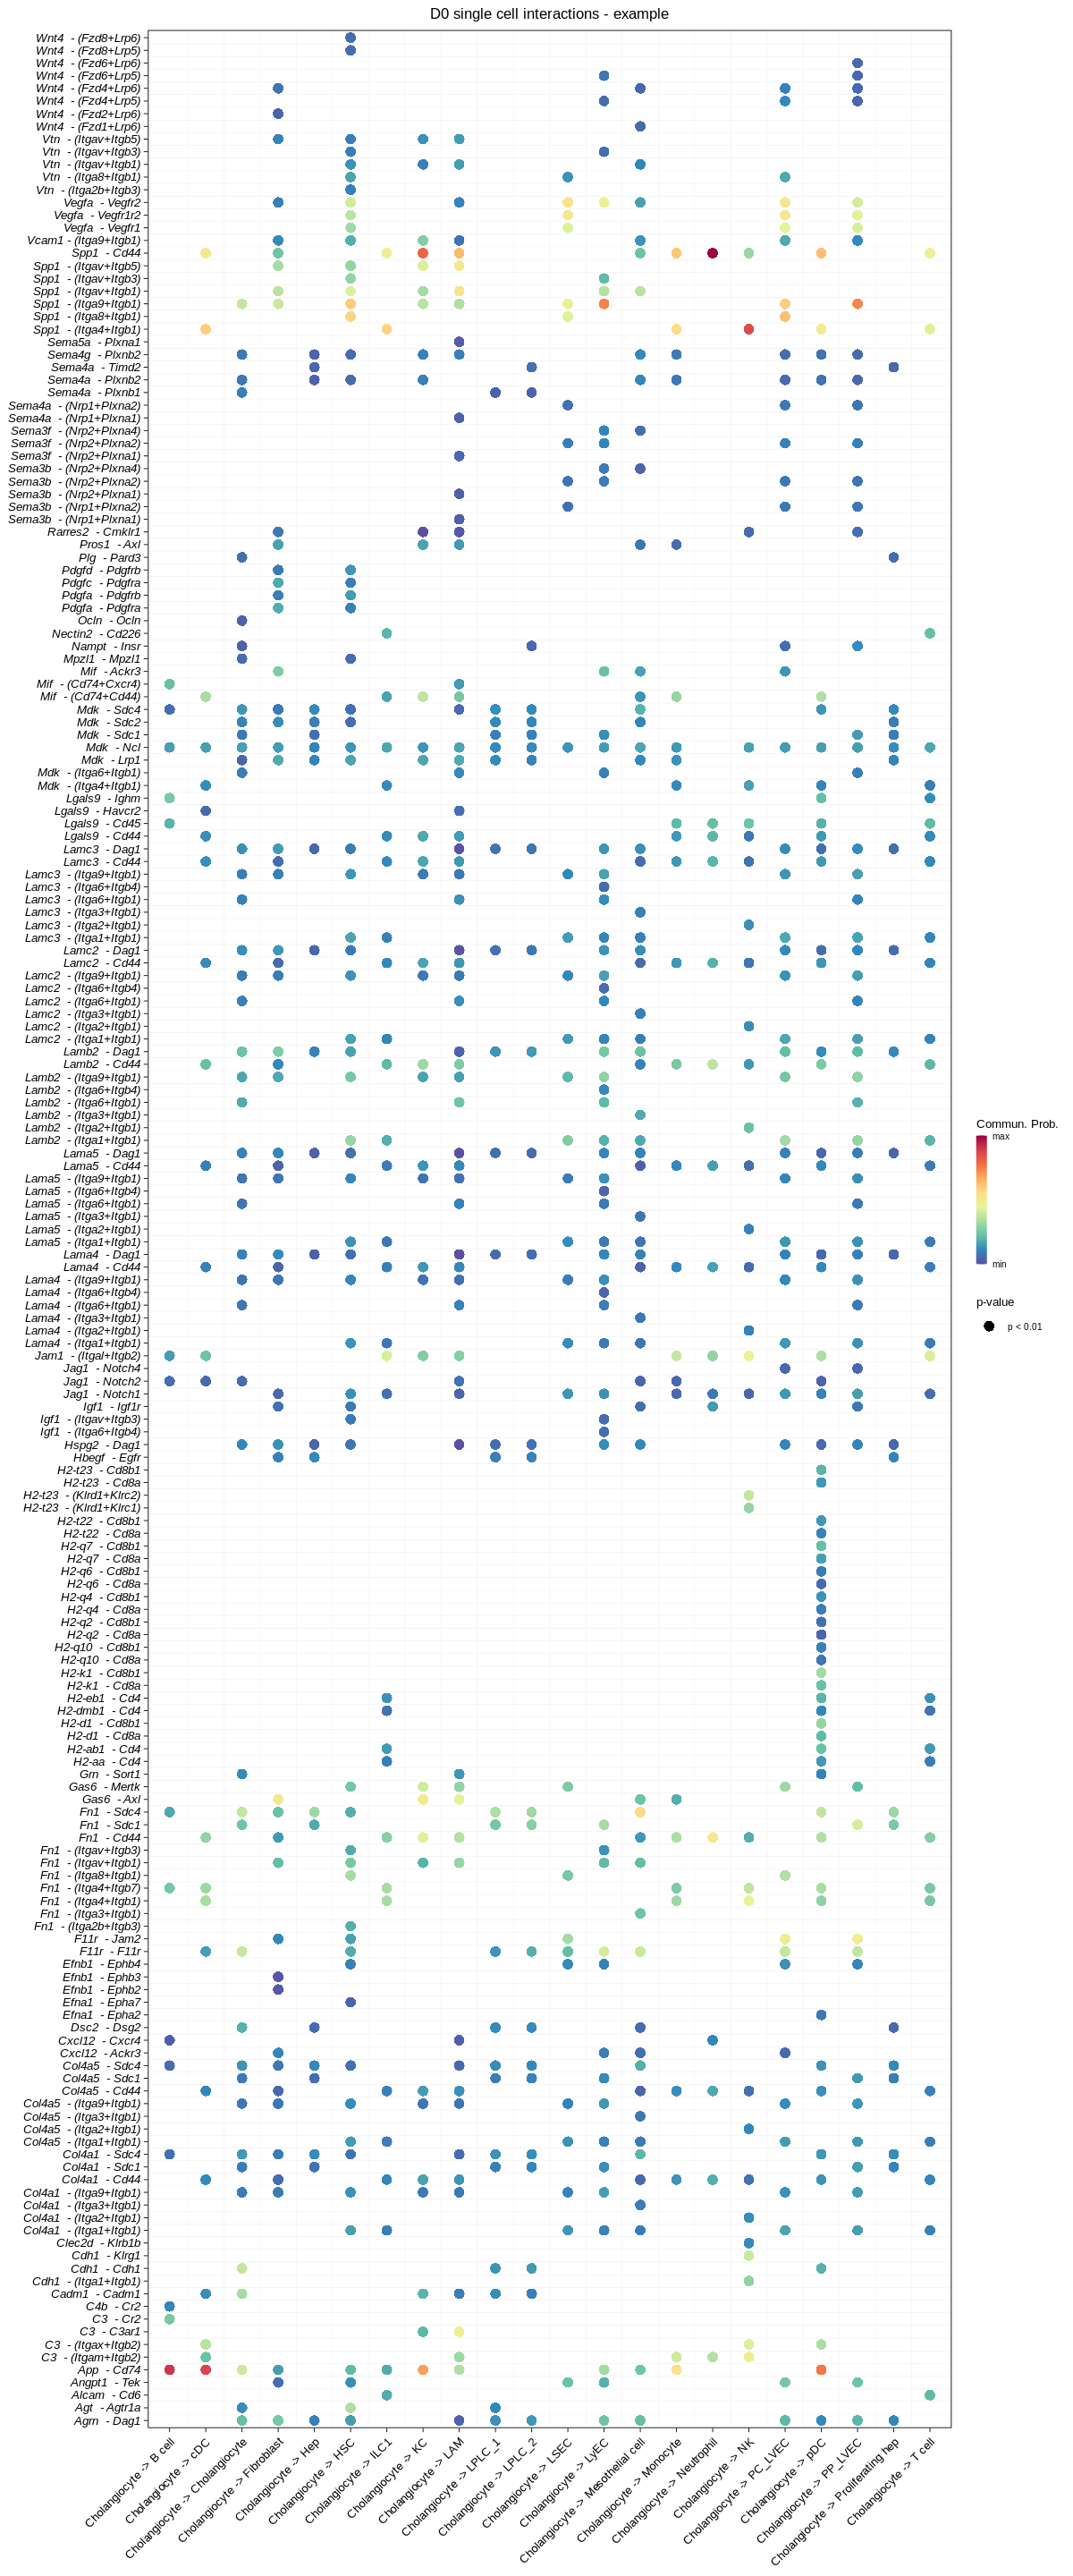

In [35]:
# Cell-cell interactions in D0
interaction_example <- netVisual_bubble(object = cellchat_D0_s$cellchat, 
                 sources.use = "Cholangiocyte", 
                 thresh = 0.01, 
                 return.data = TRUE,
                 title.name = "D0 single cell interactions - example")

options(repr.plot.width = 10, repr.plot.height = 24)
interaction_example$gg.obj + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 0.99), 
      axis.text.y = element_text(face = "italic"))

head(interaction_example$communication, n = 3)

# Comparison analysis of multiple datasets

Here, we took single cell interaction D0 vs. D17 as an example. 

Reference
- [CellChat: Comparison analysis of multiple datasets with different cellular compositions](https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/Comparison_analysis_of_multiple_datasets_with_different_cellular_compositions.html)
- [CellChat: Full tutorial for comparison analysis of multiple datasets](https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/Comparison_analysis_of_multiple_datasets.html)

In [36]:
sc <- readRDS("CIRSTA_scRNA_D17_annotated.rds")
sc$active.ident <- factor(sc$anno_LPLCsubtype)

cellchat_D17_s <- whatCellChat(sc)

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  B cell cDC Cholangiocyte Fibroblast Hep HSC ILC1 KC LAM LPLC_1 LPLC_2 LSEC LyEC Mesothelial cell Monocyte Neutrophil NK PC_LVEC pDC PP_LVEC Proliferating hep T cell VSMC 
Issue identified!! Please check the official Gene Symbol of the following genes:  
 H2-BI H2-Ea-ps 


In [41]:
cellchat_D0 <- cellchat_D0_s$cellchat
cellchat_D17 <- cellchat_D17_s$cellchat

cat("The cell identities in single cell interaction D0: ", levels(cellchat_D0@idents), "\n\n")
cat("The cell identities in single cell interaction D17: ", levels(cellchat_D17@idents), "\n\n")

The cell identities in single cell interaction D0:  B cell cDC Cholangiocyte Fibroblast Hep HSC ILC1 KC LAM LPLC_1 LPLC_2 LSEC LyEC Mesothelial cell Monocyte Neutrophil NK PC_LVEC pDC PP_LVEC Proliferating hep T cell 

The cell identities in single cell interaction D17:  B cell cDC Cholangiocyte Fibroblast Hep HSC ILC1 KC LAM LPLC_1 LPLC_2 LSEC LyEC Mesothelial cell Monocyte Neutrophil NK PC_LVEC pDC PP_LVEC Proliferating hep T cell VSMC 



In [37]:
object.list <- list(
    D0 = cellchat_D0,
    D17 = cellchat_D17
)

# Merge datasets
cellchat.D0D17 <- mergeCellChat(object.list, add.names = names(object.list), merge.data = TRUE)
cellchat.D0D17 <- liftCellChat(cellchat.D0D17)

Merge the following slots: 'data','data.signaling','net', 'netP','meta', 'idents', 'var.features', 'DB', and 'LR'.

The CellChat object will be lifted up using the cell labels B cell, cDC, Cholangiocyte, Fibroblast, Hep, HSC, ILC1, KC, LAM, LPLC_1, LPLC_2, LSEC, LyEC, Mesothelial cell, Monocyte, Neutrophil, NK, PC_LVEC, pDC, PP_LVEC, Proliferating hep, T cell, VSMC



Update slots object@net, object@netP, object@idents in dataset  D0 
Update slots object@net, object@netP, object@idents in dataset  D17 


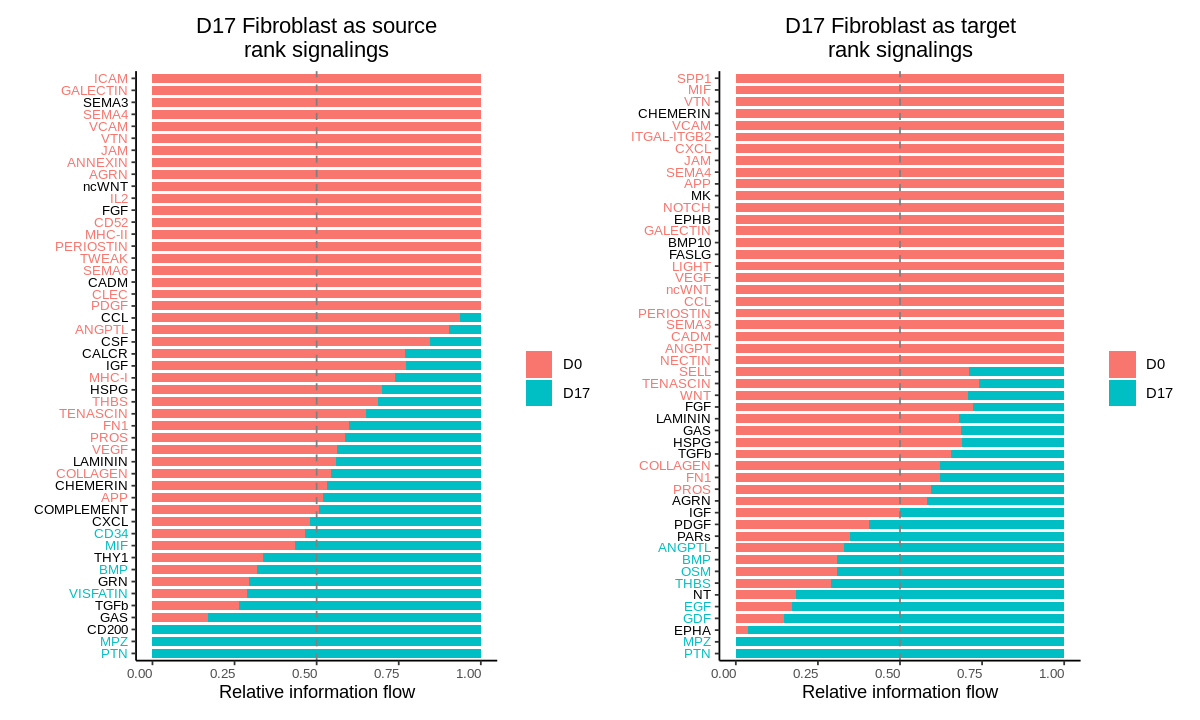

In [43]:
g1 <- rankNet(cellchat.D0D17, mode = "comparison", stacked = T, do.stat = TRUE, 
              sources.use = "Fibroblast", title = "D17 Fibroblast as source\nrank signalings",
              #signaling = selected.source.pathways
             )
g2 <- rankNet(cellchat.D0D17, mode = "comparison", stacked = T, do.stat = TRUE, 
              targets.use = "Fibroblast", title = "D17 Fibroblast as target\nrank signalings", 
              #signaling = selected.target.pathways
             )

options(repr.plot.width = 10, repr.plot.height = 6)
g <- g1 + g2
print(g)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 24)
interaction_example$gg.obj + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 0.99), 
      axis.text.y = element_text(face = "italic"))

head(interaction_example$communication, n = 3)

Comparing communications on a merged object 




,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence,source.target,prob.original,group.names,dataset
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>
1185,Fibroblast,B cell,App,Cd74,0.6010991,3,APP_CD74,App - Cd74,APP,Cell-Cell Contact,PMID: 19849849,Fibroblast -> B cell (D0),0.1894520,Fibroblast -> B cell,D0
1186,Fibroblast,cDC,App,Cd74,0.5838423,3,APP_CD74,App - Cd74,APP,Cell-Cell Contact,PMID: 19849849,Fibroblast -> cDC (D0),0.1803616,Fibroblast -> cDC,D0
2329,Fibroblast,B cell,App,Cd74,0.7971335,3,APP_CD74,App - Cd74,APP,Cell-Cell Contact,PMID: 19849849,Fibroblast -> B cell (D17),0.2852198,Fibroblast -> B cell,D17


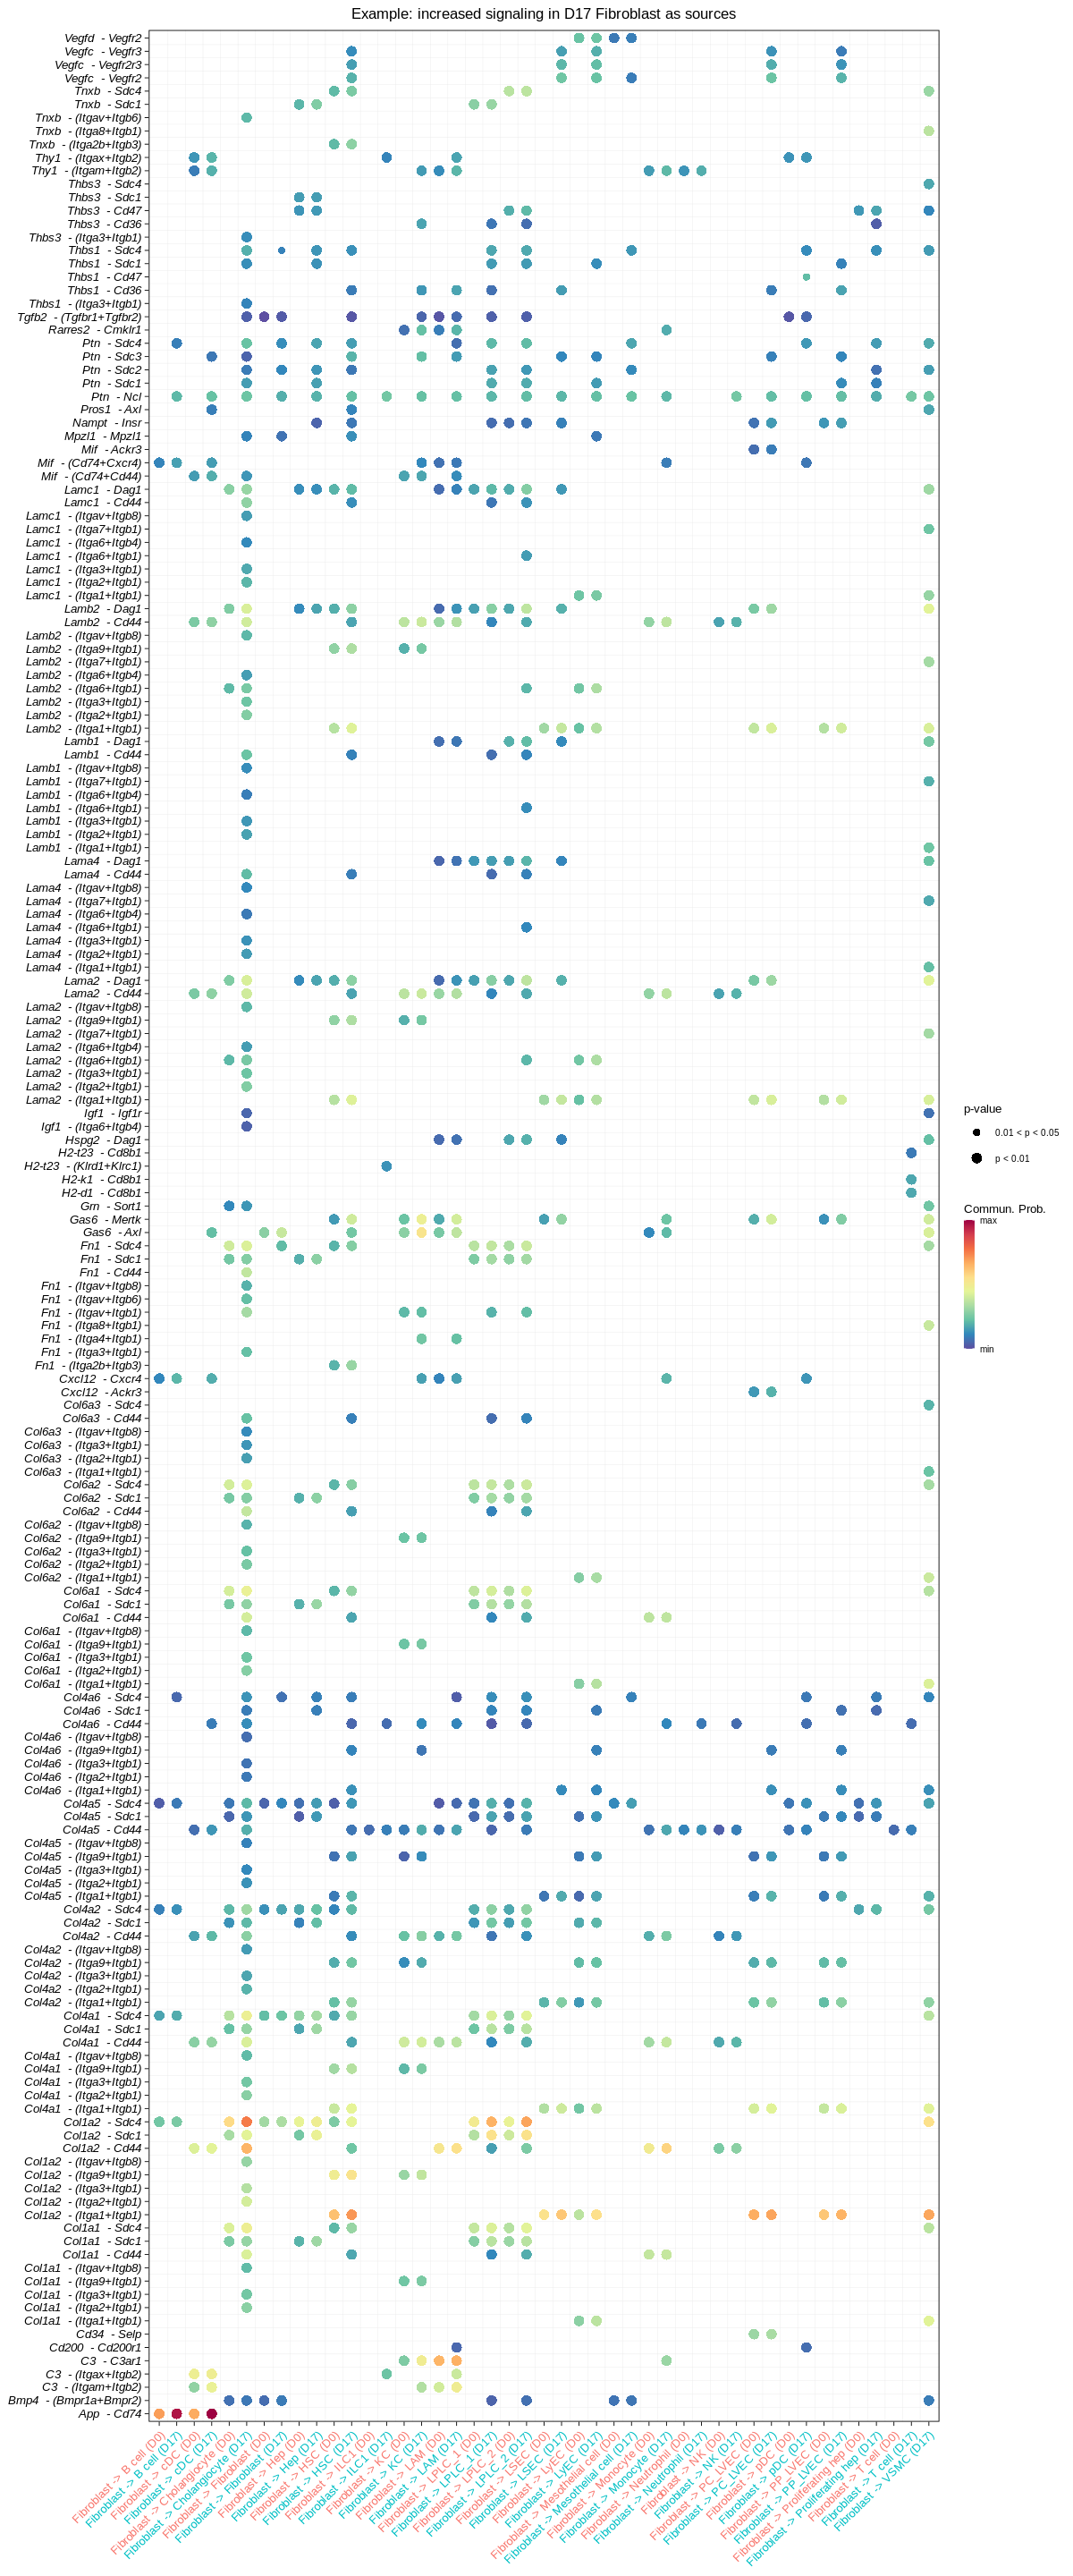

In [58]:
# Cell-cell interactions D17 vs. D0
interaction_example <- netVisual_bubble(cellchat.D0D17, 
                                        title.name = "Example: increased signaling in D17 Fibroblast as sources",
                                        sources.use = "Fibroblast", 
                                        comparison = c(1, 2), max.dataset = 2, 
                                        remove.isolate = T,  return.data = TRUE)

head(interaction_example$communication, n = 3)

options(repr.plot.width = 10, repr.plot.height = 24)
interaction_example$gg.obj + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 0.99), 
      axis.text.y = element_text(face = "italic"))

In [55]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.6 (Maipo)

Matrix products: default
BLAS/LAPACK: /sibcb1/huilijianlab1/tuxinyi/miniconda/envs/R/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.2     SeuratObject_4.1.3  Seurat_4.3.0       
[4] CellChat_1.5.0      Biobase_2.54.0      BiocGenerics_0.40.0
[7] ggplot2_3.3.6       igraph_1.4.3        dplyr_1.0.10       

loaded via a namespace (and not attached):
  [1] uuid_1.1-0             bac